In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(42)
n_samples = 2000
filter_order = 9  # M=9 -> 10 taps

# Entrada: Sinal correlacionado (simulando voz/áudio)
x_raw = np.random.randn(n_samples) + 1j*np.random.randn(n_samples)
x = np.convolve(x_raw, [1, 0.8, 0.3], mode='same') # Adiciona correlação

# Planta Desconhecida (Caminho do Eco)
w_true = np.array([0.1, -0.2+0.1j, 0.5, 0.3j, -0.1, 0.05, -0.02j, 0.01, 0.01, -0.01j])

# Geração do sinal desejado d[k] com ruído de fundo
noise = 0.01 * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))
d = np.zeros(n_samples, dtype=complex)
for k in range(len(w_true), n_samples):
    reg = x[k : k - len(w_true) : -1]
    d[k] = np.vdot(w_true, reg) + noise[k]

# --- 2. EXECUÇÃO DO FILTRO SM-AP ---
# L: Ordem de projeção (Data reuse)
# gamma_bar: Limiar de erro (Cota superior para o ruído)
L_order = 3
g_bar = 0.05  # Se |e| < 0.05, não atualiza
g_vector = np.zeros(L_order + 1, dtype=complex) # Vetor de erro alvo a posteriori

filt_smap = pdf.SMAffineProjection(
    filter_order=filter_order,
    gamma_bar=g_bar,
    gamma_bar_vector=g_vector,
    L=L_order,
    gamma=1e-4  # Regularização para evitar singularidade em X^H X
)

result = filt_smap.optimize(x, d, verbose=True, return_internal_states=True)

[SM-AP] Updates: 34/2000 | Runtime: 12.02 ms


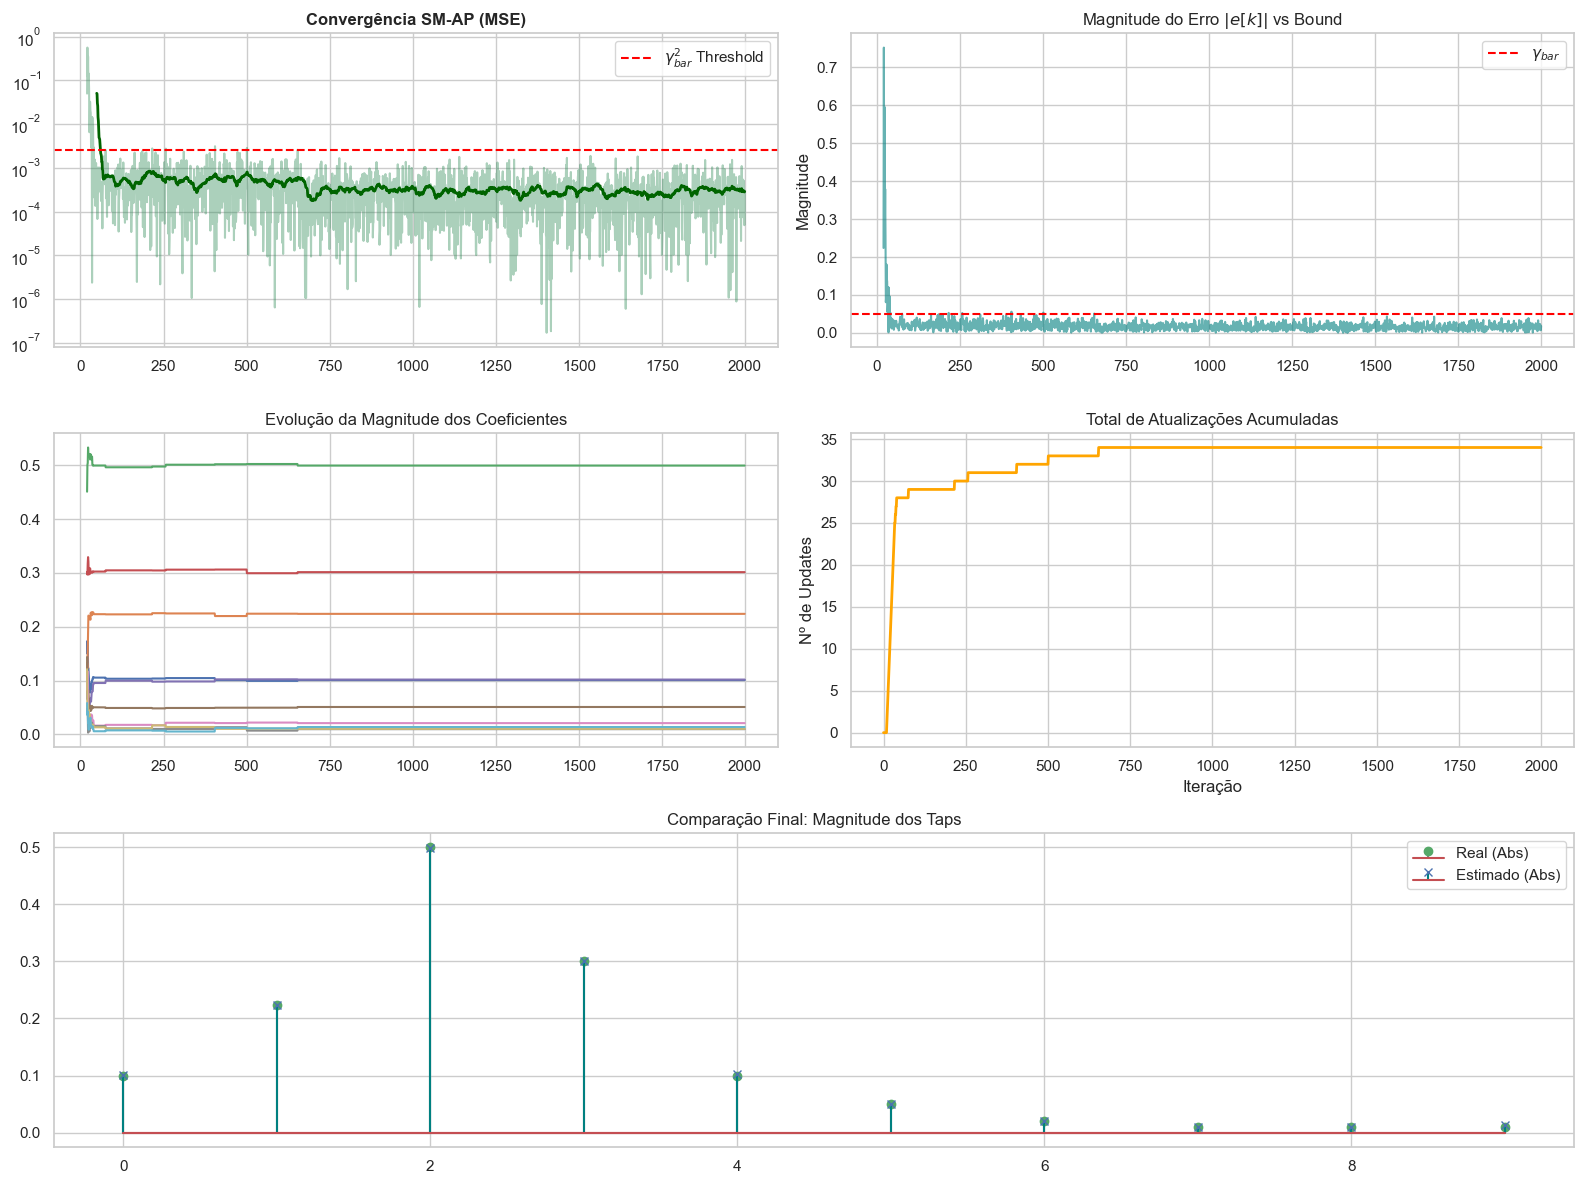

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO (SEM TRANSIENTE INICIAL) ---
def plot_smap_dashboard(result, w_true, offset=20):
    sns.set_theme(style="whitegrid")
    
    mse = result.mse()[offset:]
    err_mag = np.abs(result.errors)[offset:]
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='seagreen', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(30).mean(), color='darkgreen', lw=2)
    ax1.axhline(y=g_bar**2, color='red', linestyle='--', label=r'$\gamma_{bar}^2$ Threshold')
    ax1.set_title("Convergência SM-AP (MSE)", fontweight='bold')
    ax1.legend()

    # B. Magnitude do Erro Instantâneo vs Limiar
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, err_mag, color='teal', alpha=0.6)
    ax2.axhline(y=g_bar, color='red', linestyle='--', label=r'$\gamma_{bar}$')
    ax2.set_title(r"Magnitude do Erro $|e[k]|$ vs Bound")
    ax2.set_ylabel("Magnitude")
    ax2.legend()

    # C. Evolução dos Pesos (Magnitude)
    ax3 = fig.add_subplot(gs[1, 0])
    coeffs = np.abs(np.array(result.coefficients)[1:])[offset:]
    ax3.plot(t, coeffs)
    ax3.set_title("Evolução da Magnitude dos Coeficientes")

    # D. Esparsidade de Atualização (Cumulative)
    ax4 = fig.add_subplot(gs[1, 1])
    # Simulando a contagem de atualizações ao longo do tempo
    updates = (np.abs(result.errors) > g_bar).astype(int)
    ax4.plot(np.cumsum(updates), color='orange', lw=2)
    ax4.set_title("Total de Atualizações Acumuladas")
    ax4.set_xlabel("Iteração")
    ax4.set_ylabel("Nº de Updates")

    # E. Comparação Final de Coeficientes (Complex Plane)
    ax5 = fig.add_subplot(gs[2, :])
    w_final = result.coefficients[-1]
    ax5.stem(np.arange(len(w_true)), np.abs(w_true), linefmt='gray', markerfmt='go', label='Real (Abs)')
    ax5.stem(np.arange(len(w_true)), np.abs(w_final), linefmt='teal', markerfmt='bx', label='Estimado (Abs)')
    ax5.set_title("Comparação Final: Magnitude dos Taps")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_smap_dashboard(result, w_true, offset=20)